# DNNを用いた推論(浦田先輩の再現実験用)

### モジュールのインポート

In [1]:
import numpy as np

# 自作モジュール
import utills.datapath as dpath
import utills.preprocess as pp

### データセットに前処理を行う

In [2]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class dataset(Dataset):
    def __init__(self, paths, concat=True, transforms=None):
        self.transforms = transforms
        self.concat = concat

        # データを格納する配列を確保
        if concat:
            self.train_cepstrum = np.empty((0, 100))  # 100要素の配列
        else:
            self.train_cepstrum = []
        self.train_posture = np.empty(0)  # 姿勢データ配列

        # データ読み込みと前処理
        for p in paths:
            left, right, posture = pp.slicer(p)
            cepstrum = pp.cmn_denoise(left, right, concat=concat)
            for cep in cepstrum:
                if concat:
                    self.train_cepstrum = np.vstack((self.train_cepstrum, cep)) if self.train_cepstrum.size else cep
                else:
                    self.train_cepstrum.append(cep)
            self.train_posture = np.append(self.train_posture, posture) if self.train_posture.size else posture

    def __len__(self):
        return len(self.train_posture)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        cepstrum = torch.tensor(self.train_cepstrum[idx], dtype=torch.float32)
        posture = torch.tensor(self.train_posture[idx]-1, dtype=torch.long)
        if self.transforms is not None:
            cepstrum = self.transforms(cepstrum)
            posture = self.transforms(posture)
        return cepstrum, posture
    

### 実験の再現性担保のためのシード値固定
ついでにCudaのセットアップ

In [3]:
import torch
import random
import os

def seed_everything(seed=0):
    random.seed(seed)  # Python標準のrandomモジュールのシードを設定
    os.environ['PYTHONHASHSEED'] = str(seed)  # ハッシュ生成のためのシードを環境変数に設定
    np.random.seed(seed)  # NumPyの乱数生成器のシードを設定
    torch.manual_seed(seed)  # PyTorchの乱数生成器のシードをCPU用に設定
    torch.cuda.manual_seed(seed)  # PyTorchの乱数生成器のシードをGPU用に設定
    torch.backends.cudnn.deterministic = True  # PyTorchの畳み込み演算の再現性を確保

seed_everything()  # 上述のシード設定関数を呼び出し

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 実験データの用意

In [4]:
# 被験者
identity = dpath.LMH.L001.value.fl_center
# バッチサイズ
batch_size = 128
# データの形
concat = True

# 訓練データのパスを取得
train_type, train_tester, train_mattress, train_position = dpath.getattributes(identity)
val_tester = 'M004'
train_paths = []
for mat in dpath.mattress_all():
    if mat == train_mattress:
        continue
    train_paths.extend(eval(f"dpath.{train_type}.search('{mat}', skip=[dpath.{train_type}.{train_tester}])"))
    train_paths.extend(dpath.YMGT.search('ka'))
# train_paths = dpath.extract_position(train_paths, position=train_position)
train_paths = dpath.filter(train_paths, val_tester)

# 検証データのパスを取得
validation_paths = eval(f"dpath.LMH.{val_tester}.value.all()")
for i in range(len(validation_paths)):
    validation_paths[i] = validation_paths[i].value
validation_paths = dpath.filter(validation_paths, train_mattress)

# テストデータのパスを取得
test_path = [identity.value]

print("--- train ---")
train = dataset(train_paths, concat=concat)
print("--- validation ---")
val = dataset(validation_paths, concat=concat)
print("--- test ---")
test = dataset(test_path, concat=concat)

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True,
    drop_last = True
)

test_loader = DataLoader(
    test,
    shuffle=False,
)

--- train ---
raw\YMGT\YMGT_6\ka_center | data[170 / 193]
raw\YMGT\YMGT_3\ka_center | data[288 / 463]
raw\LMH\L003\ka_center | data[217 / 283]
raw\LMH\M001\ka_left | data[204 / 301]
raw\YMGT\YMGT_4\ka_left | data[162 / 193]
raw\LMH\M003\ka_left | data[230 / 399]
raw\YMGT\YMGT_7\ka_right | data[183 / 283]
raw\LMH\H002\st_center | data[194 / 230]
raw\YMGT\YMGT_11\ka_left | data[191 / 253]
raw\YMGT\YMGT_10\ka_left | data[170 / 193]
raw\LMH\H003\st_center | data[340 / 403]
raw\YMGT\YMGT_1\ka_left | data[168 / 178]
raw\YMGT\YMGT_5\ka_center | data[179 / 341]
raw\LMH\H002\ka_center | data[168 / 223]
raw\YMGT\YMGT_8\ka_left | data[214 / 328]
raw\YMGT\YMGT_2\ka_left | data[167 / 187]
raw\LMH\M001\ka_right | data[204 / 310]
raw\YMGT\YMGT_4\ka_right | data[151 / 268]
raw\LMH\M002\ka_left | data[218 / 321]
raw\LMH\L003\ka_left | data[209 / 253]
raw\LMH\M003\ka_right | data[243 / 578]
raw\YMGT\YMGT_9\ka_center | data[291 / 411]
raw\YMGT\YMGT_6\ka_left | data[219 / 388]
raw\YMGT\YMGT_3\ka_left | da

### 学習と推論を交互に行い、モデルの性能を評価

In [5]:
import copy
import torch.optim as optim
import torch.nn as nn
import model.dnn as dnn
from torcheval.metrics import MulticlassConfusionMatrix

# モデルのインスタンス化
num_channel = 1
net = dnn.dnn(n_input=100, n_output=4).to(device)
model = copy.deepcopy(net)

# 誤差関数を交差エントロピーで計算
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adamax(net.parameters(), lr=0.002)

confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)

train_accuracy, val_accuracy, test_accuracy = [], [], []
train_error, val_error, test_error = [], [], []
minimum_val_loss = 1e+100
early_stopping_count = 0
total_epoch = 0

# 学習
n_epoch = 100
for epoch in range(n_epoch):
    # 精度と損失の初期化
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_val = 0, 0
    test_loss, test_acc = 0, 0
    n_test = 0

    # 学習
    for train_input, train_label in train_loader:
        n_train += len(train_label)

        # 入力と正解ラベルをGPU上に移動
        input = train_input.to(device)
        label = train_label.to(device)
        # print(f'input : {input.shape}, label : {label.shape}')

        # モデルを学習モードに変更
        net.train()

        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == label).sum().item()

    # 検証
    for val_input, val_label in val_loader:
        n_val += len(val_label)

        val_input = val_input.to(device)
        val_label = val_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            val_output = net(val_input)
        loss = criterion(val_output, val_label)

        val_predicted = torch.max(val_output, 1)[1]
        
        val_loss += loss.item()
        val_acc += (val_predicted == val_label).sum().item()
        if epoch+1 == n_epoch:
            confusion_mat.update(val_predicted, val_label)

    # テスト
    for test_input, test_label in test_loader:
        n_test += len(test_label)

        test_input = test_input.to(device)
        test_label = test_label.to(device)

        # モデルを推論モードに変更
        net.eval()

        with torch.no_grad():
            test_output = net(test_input)
        loss = criterion(test_output, test_label)

        test_predicted = torch.max(test_output, 1)[1]

        test_loss += loss.item()
        test_acc += (test_predicted == test_label).sum().item()
        
    # 精度を確率に変換
    test_acc /= n_test
    test_loss = test_loss / n_test

    print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}")

    # 精度を確率に変換
    train_acc /= n_train
    val_acc /= n_val
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val

    # lossが最小の箇所のモデルを保存
    if val_loss < minimum_val_loss:
        minimum_val_loss = val_loss
        model = copy.deepcopy(net)
        early_stopping_count = 0

    train_accuracy.append(train_acc*100)
    val_accuracy.append(val_acc*100)
    test_accuracy.append(test_acc*100)
    train_error.append(train_loss)
    val_error.append(val_loss)
    test_error.append(test_loss)

    print(f"Epoch[{epoch+1}/{n_epoch}] | train_loss: {train_loss:.5f} | train_acc: {train_acc:.5f} | val_loss: {val_loss:.5f} | val_acc: {val_acc:.5f}")

    # 最小lossの更新が当分なければbreak
    if early_stopping_count >= 20:
        break


loss : 0.68641, acc : 0.76023
Epoch[1/100] | train_loss: 0.76665 | train_acc: 0.69045 | val_loss: 0.53107 | val_acc: 0.77344
loss : 0.73499, acc : 0.69591
Epoch[2/100] | train_loss: 0.57108 | train_acc: 0.78290 | val_loss: 0.61310 | val_acc: 0.75469
loss : 0.66262, acc : 0.76608
Epoch[3/100] | train_loss: 0.49915 | train_acc: 0.80720 | val_loss: 0.56266 | val_acc: 0.77500
loss : 0.75408, acc : 0.68421
Epoch[4/100] | train_loss: 0.46014 | train_acc: 0.82405 | val_loss: 0.60718 | val_acc: 0.75781
loss : 0.73249, acc : 0.67251
Epoch[5/100] | train_loss: 0.41412 | train_acc: 0.84479 | val_loss: 0.66100 | val_acc: 0.75000
loss : 0.79608, acc : 0.66667
Epoch[6/100] | train_loss: 0.38396 | train_acc: 0.85573 | val_loss: 0.71965 | val_acc: 0.73906
loss : 0.72686, acc : 0.72515
Epoch[7/100] | train_loss: 0.36489 | train_acc: 0.86562 | val_loss: 0.67175 | val_acc: 0.76719
loss : 0.72239, acc : 0.74269
Epoch[8/100] | train_loss: 0.34493 | train_acc: 0.87109 | val_loss: 0.70083 | val_acc: 0.75000


精度の可視化

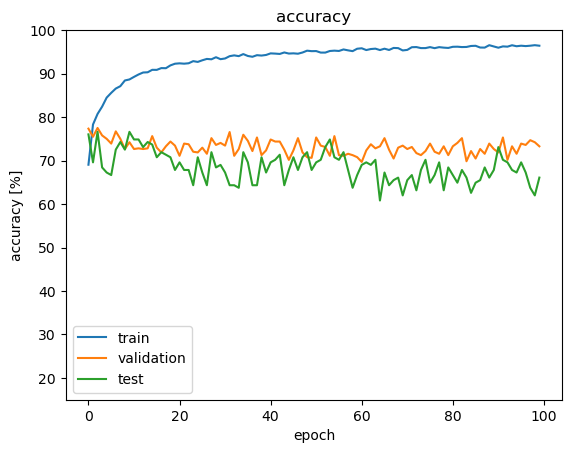

In [6]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_accuracy, label="train")
plt.plot(x, val_accuracy, label="validation")
plt.plot(x, test_accuracy, label="test")

# グラフのタイトルと軸ラベルの作成
plt.ylim(15, 100)
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy [%]")
plt.legend()
plt.savefig("../images/accuracy.jpg")

損失の可視化

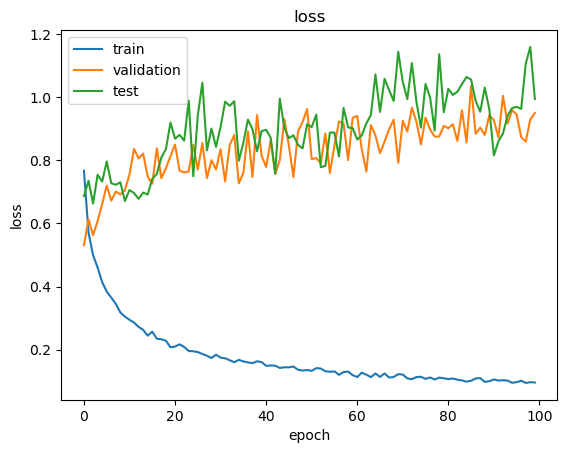

In [7]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_error, label="train")
plt.plot(x, val_error, label="validation")
plt.plot(x, test_error, label="test")

# グラフのタイトルと軸ラベルの作成
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("../images/loss.jpg")

### 最終epochのモデルを用いた推論
各種スコアと混同行列を作成

loss : 1.83028, acc : 0.76023, recall : 0.76023, precision : 0.76023, f1_score : 0.76023
tensor([[36.,  6.,  6.,  1.],
        [ 0., 36.,  1.,  0.],
        [ 3.,  0., 33.,  5.],
        [14.,  0.,  5., 25.]])


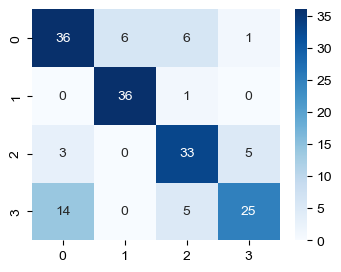

In [8]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics import MulticlassConfusionMatrix

accuracy = MulticlassAccuracy(
        average = "micro",
        num_classes = 4
)
recall = MulticlassRecall(
        average = "micro",
        num_classes = 4
)
precision = MulticlassPrecision(
        average = "micro",
        num_classes = 4
)
f1_score = MulticlassF1Score(
        average = "micro",
        num_classes = 4 
)
confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)
loss = 0
n = 0

for input, label in test_loader:
        n += len(test_label)

        input = input.to(device)
        label = label.to(device)

        output = model(input)
        test_loss = criterion(output, label)

        predicted = torch.max(output, 1)[1]

        loss += test_loss.item()
        accuracy.update(predicted, label)
        recall.update(predicted, label)
        precision.update(predicted, label)
        f1_score.update(predicted, label)
        confusion_mat.update(predicted, label)
        
# 精度を確率に変換
acc = accuracy.compute().item()
recall = recall.compute().item()
precision = precision.compute().item()
f1_score = f1_score.compute().item()
confusion_mat = confusion_mat.compute()
test_loss = test_loss * batch_size / n_test

print(f"loss : {test_loss:.5f}, acc : {acc:.5f}, recall : {recall:.5f}, precision : {precision:.5f}, f1_score : {f1_score:.5f}")
print(confusion_mat)

import utills.record_utillities as ru
confusion_mat = confusion_mat.to('cpu').detach().numpy().copy()
ru.save_confusion_matrix(confusion_mat)